In [789]:
import os
import glob
import argparse
import pandas as pd
from collections import defaultdict
def rec_dd():
    return defaultdict(rec_dd)

## 數據位置

In [790]:
CONCEPT_CSV_PATH = "statistics/ddf--concepts.csv"
TAG_CSV_PATH = "statistics/ddf--entities--tag.csv"
RELATIVE_BLOG_PATH = "../../blog/leemengtaiwan.github.io/"

ETL
- 原始英文檔案 -> 翻譯 -> 加入 metadata（如台灣指摽數、最早年份等）

檔案種類
- BACKUP -> TRANSLATED -> FINAL

In [791]:
BACKUP_CONCEPT_CSV_PATH = CONCEPT_CSV_PATH + '.backup'
BACKUP_TAG_CSV_PATH = TAG_CSV_PATH + '.backup'

TRANSLATED_CONCEPT_CSV_PATH = CONCEPT_CSV_PATH + '.translated'
TRANSLATED_TAG_CSV_PATH = TAG_CSV_PATH + '.translated'

FINAL_CONCEPT_PATH = CONCEPT_CSV_PATH + '.final'

## 結合標籤以及指標檔案的訊息，並找出台灣相關訊息
- 找出有哪些指標有台灣數據
- 建立一個 dict，方便之後建立 dataframe 
- 沒有台灣數據的指標也會被包含，只是沒有台灣相關數據

In [792]:
num_available, total = 0, 0
indicator_twn_tuples = list()  # format of a single tuple: (indicator_name, #twn rows, earliest available year)
concept_metadata = rec_dd()  # {top_tag: second_layer_tag: {concept_name, num_year_available, earliest_year} }

# read in concept/tag DDF files for easy-understanding indicator names and build concept structure
df_c = pd.read_csv(BACKUP_CONCEPT_CSV_PATH)
df_t = pd.read_csv(TRANSLATED_TAG_CSV_PATH)
df_metadata = pd.merge(df_c, df_t, how='left', left_on='tags', right_on='tag')

# parse all ddf files provided by GapMinder and find how many of them with Taiwan statistics
for f_path in glob.glob(os.path.join('statistics', '*datapoints*.csv')):
    total += 1
    df = pd.read_csv(f_path)
    indicator = f_path.replace('statistics/ddf--datapoints--', '').replace('--by--geo--time.csv', '')
    
    if not 'twn' in df.geo.unique():
        num_years, earliest_year = 0, 0
    else:
        num_available += 1
        df_tw = df[df.geo == 'twn']
        num_years, earliest_year = len(df_tw), min(df_tw['time'])
        indicator_twn_tuples.append((indicator, num_years, earliest_year))
        
        
    # generate concept structure
    ancestors = list()
    row_values = df_metadata[df_metadata['concept'] == indicator].values[0]
    concept, name_catalog, parent, ancestor = (row_values[i] for i in [0, 9, 17, 18])
    if type(parent) is str:
        ancestors.append(parent)
    
    # get ancestors recursively
    while type(ancestor) is str:
        tag_row_values = df_t[df_t['tag'] == ancestor].values[0]
        ancestors.append(tag_row_values[1])
        ancestor = tag_row_values[2]
    ancestors = ancestors[::-1]
    
    if '精神健康' in ancestors:
        print(indicator, ancestors)

    # save result into concept dict
    d = concept_metadata
    for tag in ancestors:
        d = d[tag]

    # indicators at the top-level
    if d == concept_metadata:
        indicator = 'top_indicators' + '_' + indicator

    d[indicator] = {
        'concept': concept,
        'name_catalog': name_catalog,
        'raw_name': indicator,
        'num_years': num_years,
        'earliest_year': earliest_year,
    }    

print(f"Total number of indicators: {total}, #indicators with Taiwan data: {num_available}")
print("{:.1f}% datapoints have Taiwan statistics".format(num_available / float(total) * 100))


suicide_total_deaths ['健康', '精神健康']
suicide_per_100000_people ['健康', '精神健康']
Total number of indicators: 535, #indicators with Taiwan data: 207
38.7% datapoints have Taiwan statistics


## 產生一個包含所有指標、標籤資訊的 DataFrame
- 建立 1 個 DataFrame
    - columns = ['name', 'num_idrs', 'type', 'num_tw_rows', 'earilest_year', 'parent', 'num_tw_idrs', 'concept']
    - type = [top_tag, other_tag, indicator, top_indicator] 其中一種
    - 如果 type 是 `indicator`, name 就會是 `name_catalog`, 否則為 tag_name
    - 如果 type 為 tag, 則沒有 year 相關資料

In [793]:
verbose = False

In [794]:
dic = {}
rows = []
for top_tag, d in concept_metadata.items():
    num_indicators_for_top_tag, num_idr_top_tw = 0, 0
    if type(d) is dict:
        if verbose: print(d['name_catalog'], '(有 {} 年資料，最早年份：{})'.format(d['num_years'], d['earliest_year']))
        num_indicators_for_top_tag += 1
        if d['num_years']: 
            num_idr_top_tw += 1
        rows.append([d['name_catalog'], 1, 'indicator', d['num_years'], d['earliest_year'], '', 0, d['concept']])
    else:
        
        if verbose: print(top_tag)
        
        for secondary_tag, dd in d.items():
            num_indicators_for_other_tag, num_idr_other_tw = 0, 0
            if verbose: print('\t', secondary_tag)
            if type(dd) is dict:
                num_indicators_for_other_tag += 1
                num_indicators_for_top_tag += 1
                
                if dd['num_years']: 
                    num_idr_top_tw += 1
                    num_idr_other_tw += 1
                
                if verbose: print(secondary_tag, dd)
                rows.append([dd['name_catalog'], 1, 'indicator', dd['num_years'], dd['earliest_year'], top_tag, 0, dd['concept']])
            else:
                for k, info in dd.items():
                    if type(info) is dict:
                        if verbose: print('\t\t', info['name_catalog'], '(有 {} 年資料，最早年份：{})'.format(info['num_years'], info['earliest_year']))

                        num_indicators_for_other_tag += 1
                        num_indicators_for_top_tag += 1
                        if info['num_years']: 
                            num_idr_top_tw += 1
                            num_idr_other_tw += 1

                        rows.append([info['name_catalog'], 1, 'indicator', info['num_years'], info['earliest_year'], secondary_tag, 0, info['concept']])
                    else:
                        if verbose: print('\t\t', k, info)
                
            # add other tag        
            rows.append([secondary_tag, num_indicators_for_other_tag, 'other_tag', 0, 0, top_tag, num_idr_other_tw])
        
    # add top tag / indicator
    if 'top_indicator' in top_tag:
        _type = 'top_indicator'
        concept = d['concept']
    else:
        _type = 'top_tag'
        concept = ''
    
    rows.append([top_tag, num_indicators_for_top_tag, _type, 0, 0, '', num_idr_top_tw, concept])
    dic[top_tag] = num_indicators_for_top_tag

包含所有指標、標籤的 df

In [795]:
df = pd.DataFrame(rows, columns=['name', 'num_idrs', 'type', 'num_tw_rows', 'earilest_year', 'parent', 'num_tw_idrs', 'concept'])
df.head()

,name,num_idrs,type,num_tw_rows,earilest_year,parent,num_tw_idrs,concept
0,Females aged 15+,1,indicator,40,1978,失業率,0,females_aged_15plus_unemployment_rate_percent
1,Aged 55+,1,indicator,40,1978,失業率,0,aged_65plus_unemployment_rate_percent
2,Males aged 15+,1,indicator,40,1978,失業率,0,males_aged_15plus_unemployment_rate_percent
3,Aged 55-64,1,indicator,40,1978,失業率,0,aged_55_64_unemployment_rate_percent
4,Females aged 55-64,1,indicator,40,1978,失業率,0,females_aged_55_64_unemployment_rate_percent


## 統計各個分類有多少指標包含台灣數據並畫圖
生成後放到 blog 資料夾

In [796]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [797]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [798]:
!ls {RELATIVE_BLOG_PATH}'content/images/gapminder/gapminder-indicators-with-twn.svg'

../../blog/leemengtaiwan.github.io/content/images/gapminder/gapminder-indicators-with-twn.svg


In [799]:
df_top_tag = df[df.type == 'top_tag'].loc[:, ['name', 'num_tw_idrs']].sort_values('num_tw_idrs')
df_top_tag

,name,num_tw_idrs
570,公共建設,1
628,社會,3
273,人口,4
545,能源,8
213,經濟,9
511,環境,14
612,教育,18
136,進階用途,35
59,工作,48
460,健康,63


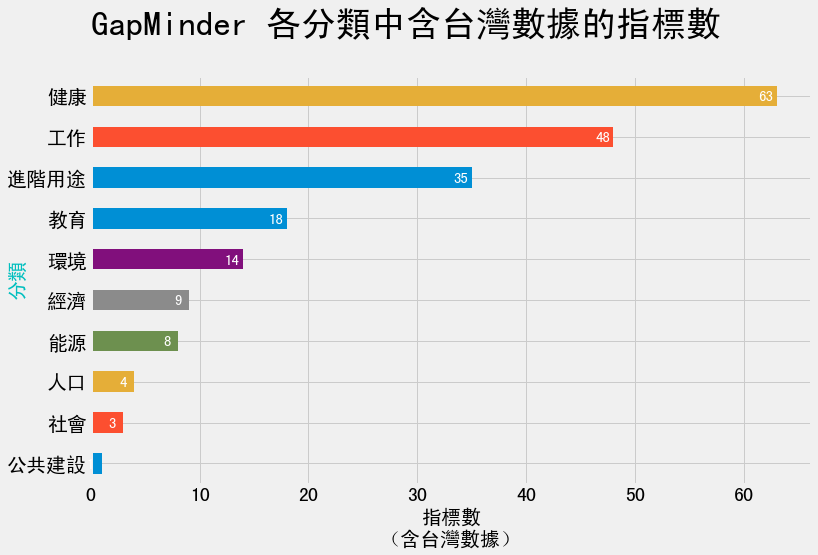

In [800]:
num_tags = len(df_top_tag.name)
ax = df_top_tag.plot('name', 'num_tw_idrs', kind='barh', figsize=(11.5, 7))
ax.legend().set_visible(False)
plt.title('GapMinder 各分類中含台灣數據的指標數\n', fontsize=35, loc='left')
ax.set_title('分類', color='c', rotation='vertical',x=-0.1,y=0.5)
plt.xlabel('指標數\n（含台灣數據）', fontsize=20)
plt.ylabel('', fontsize=20) 
plt.yticks(range(num_tags), df_top_tag.name, fontsize=20)
plt.xticks(fontsize=20)

rects = ax.get_children()[:num_tags]
for rect in rects:
    width = rect.get_width()
    if width < 1: continue
    plt.gca().text(width - 1, rect.get_y() + 0.08,
                '{}'.format(int(width)) , fontsize=15,
                ha='center', va='bottom', color='white')

plt.savefig(RELATIVE_BLOG_PATH + 'content/images/gapminder/gapminder-indicators-with-twn.svg', bbox_inches='tight')

## 更新泡泡圖選單 - 標籤
- 泡泡圖選單由 `ddf--entities--tag.csv` 定義
    - 拿翻譯結果的 `ddf--entities--tag.csv.translated` 來重新產生 `ddf--entities--tag.csv`
- 為選單裡頭每個分類加上「台灣指標數」/「總指標數」
- 複製更新後的檔案到 blog 

先為所有分類（大分類、中分類）建立
- 總指標數(todo)
- 台灣指標數

In [801]:
# !cp {BACKUP_TAG_CSV_PATH} {TRANSLATED_TAG_CSV_PATH}

In [802]:
df_t = pd.read_csv(TRANSLATED_TAG_CSV_PATH)
df_t.head()

,tag,name,parent
0,achievement,成就,education
1,advanced,進階用途,NaN
2,advanced_debt_trade,進階債務 & 貿易,advanced
3,aid_given,提供援助,economy
4,aid_received,獲得援助,economy


從 `concept_metadata` 爬出的指標／標籤數據

In [803]:
df.head()

,name,num_idrs,type,num_tw_rows,earilest_year,parent,num_tw_idrs,concept
0,Females aged 15+,1,indicator,40,1978,失業率,0,females_aged_15plus_unemployment_rate_percent
1,Aged 55+,1,indicator,40,1978,失業率,0,aged_65plus_unemployment_rate_percent
2,Males aged 15+,1,indicator,40,1978,失業率,0,males_aged_15plus_unemployment_rate_percent
3,Aged 55-64,1,indicator,40,1978,失業率,0,aged_55_64_unemployment_rate_percent
4,Females aged 55-64,1,indicator,40,1978,失業率,0,females_aged_55_64_unemployment_rate_percent


In [804]:
df_tmp = pd.merge(
    df_t, 
    df[df.type.isin(['top_tag', 'other_tag'])].loc[:, ['name', 'num_idrs', 'num_tw_idrs']], how='left', on='name')
df_tmp.loc[df_tmp.isnull().any(axis=1), ['parent']] = ''

df_tmp.head()

,tag,name,parent,num_idrs,num_tw_idrs
0,achievement,成就,education,2.0,2.0
1,advanced,進階用途,,62.0,35.0
2,advanced_debt_trade,進階債務 & 貿易,advanced,6.0,0.0
3,aid_given,提供援助,economy,12.0,0.0
4,aid_received,獲得援助,economy,3.0,0.0


只更改有指標數據的標籤名稱

In [805]:
df_tmp.loc[~df_tmp.isnull().any(axis=1), 'name'] = \
    df_tmp['name'] + '（' + df_tmp['num_tw_idrs'].fillna(0).map(int).map(str) \
    + '/' + df_tmp['num_idrs'].fillna(0).map(int).map(str) +  '）'
df_tmp.head()

,tag,name,parent,num_idrs,num_tw_idrs
0,achievement,成就（2/2）,education,2.0,2.0
1,advanced,進階用途（35/62）,,62.0,35.0
2,advanced_debt_trade,進階債務 & 貿易（0/6）,advanced,6.0,0.0
3,aid_given,提供援助（0/12）,economy,12.0,0.0
4,aid_received,獲得援助（0/3）,economy,3.0,0.0


更新本地端的 tag file 以及 blog 泡泡圖用的 tag file

In [806]:
df_tmp.loc[:, ['tag', 'name', 'parent']].to_csv(TAG_CSV_PATH, index=False)

In [807]:
!cp {TAG_CSV_PATH} {RELATIVE_BLOG_PATH}'output/projects/gapminder-tw/'{TAG_CSV_PATH}

## 指標翻譯
- 翻譯使用 .backup 檔案，然後產生 .translated 檔案，這樣在更新數字的時候翻譯才不會被蓋掉
- 同時利用 `df` 資料確認哪些指標有台灣數據，優先翻譯
- 翻譯完之後，利用下個步驟的[更新泡泡圖選單 - 指標](#更新泡泡圖選單---指標) 來為新翻譯好的指標加上 `earilest_year`

In [808]:
BACKUP_CONCEPT_CSV_PATH

'statistics/ddf--concepts.csv.backup'

In [809]:
df_c = pd.read_csv(BACKUP_CONCEPT_CSV_PATH).fillna('')
df_c = pd.merge(
    df_c, 
    df.loc[:, ['concept', 'earilest_year']], how='left', on='concept'
)
df_c.earilest_year = df_c.earilest_year.fillna(0).astype(int)
df_c = df_c.fillna('')
df_c.loc[:, ['concept', 'name', 'name_catalog', 'earilest_year']].head()

,concept,name,name_catalog,earilest_year
0,adults_with_hiv_percent_age_15_49,"Adults with HIV (%, age 15-49)","Adults with HIV (%, age 15-49)",0
1,age_at_1st_marriage_women,Age at 1st marriage (women),Age at 1st marriage (women),1905
2,aged_15_24_employment_rate_percent,Aged 15-24 employment rate (%),Aged 15-24,1991
3,aged_15_24_unemployment_rate_percent,Aged 15-24 unemployment rate (%),Aged 15-24,1978
4,aged_15_64_labour_force_participation_rate_per...,Aged 15-64 labour force participation rate (%),Aged 15-64,1990


In [810]:
offset, count = 0, 50

In [811]:
# df_tmp = df_c.loc[df_c.earilest_year != 0, ['concept', 'name', 'name_catalog', 'name_short']].iloc[offset:, :]
df_tmp = df_c.loc[:, ['concept', 'name', 'name_catalog', 'name_short']].iloc[offset:, :]
df_tmp.head()

,concept,name,name_catalog,name_short
0,adults_with_hiv_percent_age_15_49,"Adults with HIV (%, age 15-49)","Adults with HIV (%, age 15-49)",Adults with HIV
1,age_at_1st_marriage_women,Age at 1st marriage (women),Age at 1st marriage (women),Age at 1st marriage
2,aged_15_24_employment_rate_percent,Aged 15-24 employment rate (%),Aged 15-24,Employment rate (%)
3,aged_15_24_unemployment_rate_percent,Aged 15-24 unemployment rate (%),Aged 15-24,Unemployment rate (%)
4,aged_15_64_labour_force_participation_rate_per...,Aged 15-64 labour force participation rate (%),Aged 15-64,Labour force participation rate (%)


In [812]:
df_tmp[df_tmp.concept == 'economic_growth_over_the_past_10_years']

,concept,name,name_catalog,name_short
153,economic_growth_over_the_past_10_years,Economic growth over the past 10 years,Economic growth over past 10 years,Economic growth


### 利用預先定義的 rule-based 產生翻譯 config

In [813]:
translations_c = {}
en_to_ch = [
    ('data_quality', '數據品質'),
    ('_employment_rate_percent', '就業率（％）'),
    ('_unemployment_rate_percent', '失業率（％）'),
    ('_labour_force_participation_rate_percent', '勞動參與率（%）'),
    ('life_expectancy_', '平均壽命'),
    ('_workers_', '勞動比例'),
    ('self_employed_', '（自由業）比例'),
    ('_cancer_', '癌'),
    ('_deaths_', '死亡'),
    ('_affected_', '受{}影響人數'),
    ('_emission', '排放量'),
    ('income_', '所得'),
    ('_population', '人口'),
    ('population_', '人口'),
    ('sex_ratio_', '性別比例'),
    ('_consumption', '消耗量'),
    ('traffic_mortality', '交通事故死亡'),
    ('suicide_', '自殺身亡'),
    ('murdered_', '謀殺身亡'),
]
ens, chs = [t[0] for t in en_to_ch], [t[1] for t in en_to_ch]

In [814]:
concepts, names, catalogs, shorts = df_tmp.concept.values, df_tmp.name.values, df_tmp.name_catalog.values, df_tmp.name_short.values
for c, n, n_c, n_s in zip(concepts, names, catalogs, shorts):    
    # 看指標內有無關鍵字
    is_translation_generated = True
    
    for idx, en in enumerate(ens):
        if en in c:
            ch = chs[idx]
            terms = c.split('_')
            
            # general 性別檢視
            sex = ''
            for t in terms:
                if t in ['female', 'females', 'women']: sex = '女性'
                elif t in ['male', 'males', 'men']: sex = '男性'
                    
            # 年齡相關指標（就業率、失業率、人口）
            if 'aged' in c:
                if terms[0] == 'aged': idx_age = idx_lower = 1
                else: idx_age = idx_lower = 2 # 有性別的情況
                
                idx_high = idx_lower + 1
                name_short = ch
                if 'plus_' in c:
                    age = c.split('_')[idx_age].replace('plus', '')
                    name_catalog = age + ' 歲以上'
                else:
                    low, high = c.split('_')[idx_lower:idx_high + 1]
                    name_catalog = f'{low}-{high} 歲'
                
                name_catalog = name_catalog + ', ' + sex if sex else name_catalog
                name = name_catalog + name_short
                translations_c[c] = [name, name_catalog, name_short]
            # 癌症相關指標
            elif en == '_cancer_':
                cancers = {
                    'prostate': '攝護腺', 'stomach': '胃', 'breast': '乳', 'cervical': '子宮頸',
                    'colonandrectum': '大腸直腸', 'liver': '肝', 'lung': '肺'}
                for name in cancers:
                    if name in c: 
                        ch = cancers[name] + ch
                        break
                # sex(2) * per 100,000(2) * death/cases(2) = 8 種排列組合
                sex = '女性' if 'female' in c or 'women' in c else '男性'
                per = '（每 10 萬人）' if '_per_' in c else ''
                _type = '死亡數' if 'deaths' in c else '病例數'
                name_catalog = ch + _type + per
                name = ch + _type + ', ' + sex + per
                translations_c[c] = [name, name_catalog, name_catalog]
            # 失業 / 長期失業
            elif en == '_unemployment_rate_percent':
                if sex: sex = ', ' + sex
                long_term = '長期' if 'long_term' in c else ''
                name = name_catalog = long_term + ch + sex
                translations_c[c] = [name, name_catalog, ch]
            # 勞動力（產業別、性別）
            elif '_workers_' in c or 'self_employed_' in c:
                sectors = {
                    'agriculture': '農業', 'family': '家庭', 'industry': '工業',
                    'service': '服務業', 'salaried': '受薪', 'self': '自雇'}
                
                for t in terms:
                    if t in sectors: 
                        s = sectors[t]
                        if t == 'salaried': ch = '僱員比例'
                            
                name_short = name_catalog = sex + s + ch
                name = name_catalog + '（％, 佔全體' + sex + '就業比例）'
                translations_c[c] = [name, name_catalog, name_short]
            # 死亡/受影響數據（兒童/新生兒、每 X 人、每年天災、通報/預估）
            elif en in ['_deaths_', '_affected_']:
                human_type = ''
                if 'in_children' in c: human_type = '1-59 個月兒童'
                elif 'in_newborn' in c: human_type = '新生兒'

                death_cause = ''
                if 'diarrhoeal' in c: death_cause = '痢疾'
                elif 'tb_with_hivplus' in c: death_cause = '愛滋與結核病'  
                elif 'hiv' in c: death_cause = '愛滋'
                elif 'injury' in c: death_cause = '受傷'
                elif 'malaria' in c: death_cause = '瘧疾'
                elif 'measles' in c: death_cause = '麻疹'
                elif 'meningitis' in c: death_cause = '腦膜炎'
                elif 'ncd' in c: death_cause = '非傳染性疾病'
                elif 'other_infections' in c: death_cause = '其他傳染性疾病'
                elif 'pertussis' in c: death_cause = '百日咳'
                elif 'pneumonia' in c: death_cause = '肺炎'
                elif 'sepsis' in c: death_cause = '敗血症'
                elif 'tetanus' in c: death_cause = '破傷風'
                elif 'prematurity' in c: death_cause = '早產'
                elif 'asphyxia' in c: death_cause = '產時窒息'
                elif 'congenital' in c: death_cause = '先天性'
                elif '_tb_' in c: death_cause = '結核病'
                elif 'other_deaths' in c: death_cause = '其他'
                elif 'all_causes' in c: death_cause = '所有'
                elif 'tsunami' in c: death_cause = '海嘯'
                elif 'drought' in c: death_cause = '旱災'
                elif 'earthquake' in c: death_cause = '地震'
                elif 'epidemic' in c: death_cause = '傳染病'
                elif 'extreme_temperature' in c: death_cause = '極端溫度'
                elif 'flood' in c: death_cause = '水災'
                elif 'plane_crash' in c: death_cause = '飛機失事'
                elif 'storm' in c: death_cause = '暴風雨（雪）'
                elif 'traffic' in c: death_cause = '交通事故'
                elif 'battle' in c: death_cause = '戰爭'
                elif 'motorcycle' in c: death_cause = '摩托車'
                elif 'maternal' in c: death_cause = '孕產婦'
                elif 'burns' in c: death_cause = '燒傷'
                elif 'crude' in c: death_cause = '概略'
                elif 'poisonings' in c: death_cause = '中毒'
                elif 'falls' in c: death_cause = '摔倒'
                elif 'car' in c: death_cause = '車禍'  
                    
                if not death_cause:
                    print("No death cause: ", c)
                    continue
                    
                # 天災人禍格式 - per
                if '_per_' in c and ('_people' in c or '_population' in c or \
                                     '_estimated' in c or '_reported' in c or '_risk' in c or \
                                     'battle' in c):
                    for t in terms:
                        # 特別處理，戰爭的 concept name 跟別人不一樣
                        if t == 'battle': num_ppl = '10 萬人'
                        elif t == '1000': num_ppl = '1,000 人'
                        elif t == '100000': num_ppl = '10 萬人'
                    
                    name_catalog = name_short = death_cause + ch
                    if sex: name_catalog += f', {sex}'
                    name = name_catalog = name_catalog + f'（每 {num_ppl}）'
    
                # 天災格式 - 全年
                elif 'annual_number' in c:
                    if en == '_affected_':
                        name_short = name_catalog = ch.format(death_cause)
                    else:
                        name_short = name_catalog = '因' + death_cause + ch + '人數'
                    name = '全年' + name_catalog
                # 兒童、新生兒
                elif human_type and death_cause:
                    death_cause = death_cause + ch
                    counts = '（‰, 每 1,000 出生人數）' if '_per_' in c else '（人數）'
                    if human_type and death_cause:
                        name_catalog = death_cause + counts
                        name_short = human_type.split('（')[0] + death_cause
                        name = human_type + name_catalog
                else:
                    name_catalog = name_short = death_cause + ch
                    name = '全年' + name_catalog             
                translations_c[c] = [name, name_catalog, name_short]    
            # 人口總數/成長
            elif en in ['_population', 'population_']:
                postfix1, postfix2 = '', ''
                if 'growth_' in c:
                    postfix1 = '成長（％）'
                    postfix2 = '成長（％, 每年成長）'
                elif '_density_' in c:
                    postfix1 = postfix2 = '密度'
                    measure = ''
                    if 'square_km' in c:
                        measure = '平方公里'
                elif 'percent_of_total' in c:
                    postfix1 = '比例（％）'
                    postfix2 = '比例（％, 佔總人口的比例）'
                elif 'total' in c or sex:
                    postfix1 = postfix2 = '總數'
                    
                proj = ''
                if '_with_projections' in c:    
                    proj = ', 含預測'
                    
                prefix = ''
                if 'urban_' in c:
                    prefix = '都市'
                
                name_catalog = name_short = prefix + sex + ch + postfix1
                name = prefix + sex + ch + postfix2 + proj
                
                #overwrite
                if 'agglomerations_'in c:
                    name_catalog = name_short = '都市人口集會比例'
                    name = '都市人口集會比例（％, 在超過 100 萬都市的人口佔總人口的比例）'
                translations_c[c] = [name, name_catalog, name_short]    
            # 所得相關指標
            elif en == 'income_':
                per = '人均' if '_per_' in c else ''
                proj = ', 含預測' if 'with_projections' in c else ''
                adjust = ''
                if 'ppp_inflation_adjusted' in c:
                    adjust = '（GDP/人, 購買力平價$, 通膨調整）'
                    
                if per:
                    name_catalog = name_short = per + ch + proj
                    name = name_catalog + adjust
                
                if '_share_' in c:
                    dist = '收入份額（％）'
                    
                    group, perc, second = [''] * 3
                    if '2nd_' in c: second = '第 2 '
                    if '_10' in c: perc = '10'
                    elif '_20' in c: perc = '20'

                        
                    if 'middle' in c: group = '中間'
                    elif 'richest' in c:
                        if not second: group = '最富有'
                        else: group = '富有'
                    elif 'poorest' in c:
                        if not second: group = '最貧窮'
                        else: group = '貧窮'
                    
                    group += f'的 {perc}% '
                    
                    name_catalog = name_short = second + group + dist
                    name = second + group + '佔全體' + dist
                translations_c[c] = [name, name_catalog, name_short]
            # 污染源排放量
            elif en == '_emission':
                energy = ''
                if 'sulfur_' in c: energy = '硫化物'
                elif 'co2_' in c: energy = '二氧化碳'
                
                measure = ''
                if '_kilotonnes' in c or '1000_tonnes' in c: measure = '千噸'
                elif 'tonnes' in c: measure = '公噸'
                elif '_kg' in c: measure = '公斤'
                    
                per = f'人均' if '_per_' in c else ''
                name = name_catalog = name_short = energy + ch

                if per: name = name + f'（{measure}/人）'
                else: name = name + f'（{measure}）' 
                translations_c[c] = [name, name_catalog, name_short]
            # 平均壽命
            elif en == 'life_expectancy_':
                name_short = ch
                if 'years' in c:
                    name = name_catalog = ch
                elif 'at_birth' in c or sex:
                    if 'projections' in c or sex:
                        name = name_catalog = sex + ch + ', 包含預測'
                    elif 'ihme' in c:
                        name = name_catalog = ch + ', 數據來源：IHME'
                
                translations_c[c] = [name, name_catalog, name_short]
            elif en == 'sex_ratio_':
                postfix = '（每 100 位女性的男性數）'
                prefix = ''
                if 'above' in c:
                    age = terms[3]
                    prefix = f'超過 {age} 歲'
                elif not 'all_age_groups' in c:
                    age_l, age_h = terms[2], terms[3]
                    prefix = f'{age_l}-{age_h} 歲'
                name_catalog = name_short = prefix + ch
                name = name_catalog + postfix
                
                translations_c[c] = [name, name_catalog, name_short]
            # 能源消耗量
            elif en == '_consumption':
                energy_type = ''
                if 'coal_' in c:
                    energy_type = '煤炭'
                elif 'oil_' in c:
                    energy_type = '石油'
                    
                measure = ''
                if 'total' in c:
                    measure = '（公噸）'
                elif '_per_':
                    measure = '（公噸/人）'
                    
                name_catalog = name_short = energy_type + ch
                name = name_catalog + measure
                translations_c[c] = [name, name_catalog, name_short]
            # 交通死亡/謀殺/自殺 per 100,000 （進階用途 -> 傷亡）
            elif en in ['traffic_mortality', 'suicide_', 'murdered_']:
                if sex:
                    name = name_catalog = name_short = ch + ', ' + sex + '（每 10 萬人）'
                else:
                    if '' in en.split('_'):
                        idx_age = idx_lower = 1
                        if '_age_' in c:
                            idx_age += 1
                            idx_lower += 1
                    else:
                        dx_age = idx_lower = 2
                    idx_high = idx_lower + 1


                    
                    if '_children_' in c:
                        idx_lower += 1
                        idx_high += 1

                    if 'plus_' in c:
                        age = c.split('_')[idx_age].replace('plus', '')
                        age += ' 歲以上'
                    else:
                        low, high = c.split('_')[idx_lower:idx_high + 1]
                        age = f'{low}-{high} 歲'
                
                    name = name_catalog = name_short = ch + ', ' + age + '（每 10 萬人）'
                    
                    
                translations_c[c] = [name, name_catalog, name_short]
#                 print(name,  '|', name_catalog, '|', name_short)
#                 print('-'* 10)
                
            # 數據品質
            # consumption / production'
            else:
                pass
#                 print(c, f'找到 rule: "{en}", 等待進一步處理')
            
            # find rules, leave
            break

### 手動添加翻譯

In [815]:
manual = {
    'age_at_1st_marriage_women': ['首次結婚年齡（女性）', '首次結婚年齡（女性）', '首次結婚年齡'],
    'alternative_gdp_per_capita_ppp_pwt_7_1': ['替代人均 GDP（購買力平價$）, PWT 7.1', '人均 GDP（購買力平價$）, PWT 7.1', '人均 GDP（購買力平價$）'],
    'alternative_gdp_per_capita_ppp_pwt_8_0': ['替代人均 GDP（購買力平價$）, PWT 8.0', '人均 GDP（購買力平價$）, PWT 8.0', '人均 GDP（購買力平價$）'],
    'alternative_gdppercapita_ppp_inflation_adjusted_from_pwt': ['替代人均 GDP（購買力平價$，通膨調整）, PWT', '人均 GDP（購買力平價$，通膨調整）, PWT', '人均 GDP（購買力平價$）'],
    'average_age_of_dollar_billionaires_years': ['億萬富翁平均年齡'],
    'blood_pressure_sbp_men_mmhg': ['男性血壓（收縮壓, mmHg）', '男性血壓', '男性血壓'],
    'blood_pressure_sbp_women_mmhg': ['女性血壓（收縮壓, mmHg）', '女性血壓', '女性血壓'],
    'body_mass_index_bmi_men_kgperm2': ['男性身體質量指數（BMI,  公斤/身高平方）', '男性 BMI', 'BMI'],
    'body_mass_index_bmi_women_kgperm2': ['女性身體質量指數（BMI,  公斤/身高平方）', '女性 BMI', 'BMI'],
    'drownings_per_100000_people': ['溺水身亡（每 10 萬人）', '溺水身亡（每 10 萬人）', '溺水身亡'],
    'malnutrition_weight_for_age_percent_of_children_under_5': ['過輕兒童比例（營養不良）', '過輕兒童比例', '過輕兒童比例（營養不良）'],
    'underweight_children': ['過輕兒童比例'],
    'ifpri_underweight_children': ['過輕兒童比例, 數據來源：IFPRI', '過輕兒童比例', '過輕兒童比例'],
    'number_of_child_deaths': ['兒童死亡人數'],
    'newborn_deaths': ['新生兒死亡人數'],
    'suicide_total_deaths': ['自殺身亡'],
    'murder_total_deaths': ['謀殺身亡'],
    'children_per_woman_total_fertility': ['婦女人均嬰兒數'],
    'children_per_woman_total_fertility_with_projections': ['婦女人均嬰兒數, 包含預測'],
    'teen_fertility_rate_births_per_1000_women_ages_15_19': ['15-19 歲女性青少年生育率（每 1,000 位女性的出生數）', '青少年生育率', '青少年生育率'],
    'child_mortality_0_5_year_olds_dying_per_1000_born': ['兒童死亡率（‰, 每 1,000 出生人數的兒童死亡人數）', '兒童死亡率', '兒童死亡率（‰）'],
    'child_mortality_0_5_year_olds_more_years_version_7': ['兒童死亡率（‰, 每 1,000 出生人數的兒童死亡人數）, 版本 7, 有更多年數據', '兒童死亡率', '兒童死亡率（‰）'],
    'debt_servicing_costs_percent_of_exports_and_net_income_from_abroad': ['償債出口比（％, 債務佔出口以及海外獲利之比例）', '償債出口比（％）', '償債出口比（％）'],
    'smoking_adults_percent_of_population_over_age_15': ['吸菸比例（％, 吸菸人數佔 15 歲以上人口比例）', '吸菸比例（％）', '吸菸比例（％）'],
    'smoking_men_percent_of_men_over_age_15': ['男性吸菸比例（％, 男性吸菸人數佔 15 歲以上人口比例）', '男性吸菸比例（％）', '男性吸菸比例（％）'],
    'smoking_women_percent_of_women_over_age_15': ['吸菸比例（％, 女性吸菸人數佔 15 歲以上人口比例）', '女性吸菸比例（％）', '女性吸菸比例（％）'],
    'population_policies_aid_given_percent_of_aid': ['人口政策援助（％, 佔所有援助的比例）', '人口政策援助', '人口政策援助'],
    'tb_programme_dots_population_coverage_percent': ['結核病計畫（DOTS）涵蓋率'],
    'crude_birth_rate_births_per_1000_population': ['概略出生率（％, 每 1,000 人的出生數）', '概略出生率', '概略出生率'],
    'crude_death_rate_deaths_per_1000_population': ['概略死亡率（％, 每 1,000 人的死亡數）', '概略死亡率', '概略死亡率'],
    'median_age_years': ['所有人口的年齡中位數', '年齡中位數', '年齡中位數'],
    'children_and_elderly_per_100_adults': ['兒童及年長者數（每 100 位成人）', '兒童及年長者數', '兒童及年長者數'],
    'new_births_total_number_estimated': ['新生兒人數（估計）', '新生兒人數', '新生兒人數'],
    'alcohol_consumption_per_adult_15plus_litres': ['酒精消耗量（公升，總消耗量/15 歲人數）', '酒精消耗量', '酒精消耗量'],
    'democracy_score_use_as_color': ['民主指數（用作顏色）', '民主指數', '民主指數'],
    'suicide_per_100000_people': ['自殺身亡（每 10 萬人）'],
    'suicide_total_deaths': ['自殺身亡（總死亡數）'],
    'economic_growth_over_the_past_10_years': ['過去每 10 年經濟成長', '過去每 10 年經濟成長', '經濟成長'],
    'corruption_perception_index_cpi': ['清廉印象指數（CPI）', '清廉印象指數', '清廉印象指數'],
    'corruption_perception_index_cpi_pre2012': ['清廉印象指數（CPI, 2012 年前統計方式）', '清廉印象指數（CPI, 2012 年前統計方式）', '清廉印象指數'],
    'electricity_generation_per_person': ['人均發電量（千瓦小時）', '人均發電量', '人均發電量'],
    'electricity_generation_total': ['總發電量（千瓦小時）', '總發電量', '總發電量'],
    'electricity_use_per_person': ['人均電力消耗量'],
    'residential_electricity_use_per_person': ['人均住宅電力消耗量（千瓦小時）', '人均住宅電力消耗量', '人均住宅電力消耗量'],
    'residential_electricity_use_total': ['總住宅電力消耗量（千瓦小時）', '總住宅電力消耗量', '總住宅電力消耗量'],
    'residential_energy_use_percent': ['住宅能源消耗（％）'],
    'government_health_spending_of_total_gov_spending_percent': ['政府醫療支出佔所有支出之比例（％）', '政府醫療支出佔所有支出之比例（％）', '政府醫療支出佔所有支出之比例'],
    'government_health_spending_per_person_international_dollar': ['政府醫療支出 / 人, 國際元$', '政府醫療支出 / 人, 國際元$', '政府醫療支出'],
    'government_health_spending_per_person_us': ['政府醫療支出 / 人, 美金$', '政府醫療支出 / 人, 美金$', '政府醫療支出'],
    'government_share_of_total_health_spending_percent': ['政府醫療支出份額（％）', '政府醫療支出份額（％）', '政府醫療支出份額'],
    'total_health_spending_per_person_international_dollar': ['人均醫療支出, 國際元$', '人均醫療支出, 國際元$', '人均醫療支出'],
    'total_health_spending_per_person_us': ['人均醫療支出, 美金$', '人均醫療支出, 美金$', '人均醫療支出'],
    'total_health_spending_percent_of_gdp': ['總醫療支出佔 GDP 比例（％）', '總醫療支出佔 GDP 比例（％）', '總醫療支出'],
    'private_share_of_total_health_spending_percent': ['私人企業醫療支出份額（％）', '私人企業醫療支出份額（％）', '私人企業醫療支出份額'],
    'out_of_pocket_share_of_total_health_spending_percent': ['自費醫療支出份額（％）', '自費醫療支出份額（％）', '自費醫療支出份額'],
    'medical_doctors_per_1000_people': ['醫生人數（‰, 每千人）', '醫生人數（‰, 每千人）', '醫生人數（每千人）'],
    'cholesterol_fat_in_blood_men_mmolperl': ['男性血脂（總膽固醇, 毫摩爾/每升）', '男性血脂', '男性血脂'],
    'cholesterol_fat_in_blood_women_mmolperl': ['女性血脂（總膽固醇, 毫摩爾/每升）', '女性血脂', '女性血脂'],
    'births_attended_by_skilled_health_staff_percent_of_total': ['專業人員出生參與率（％, 佔所有出生的比例）', '專業人員出生參與率（％）', '專業人員出生參與率'],
    'stillbirths_per_1000_births': ['死胎數（每 1,000 出生）', '死胎數', '死胎數'],
    'maternal_mortality_ratio_per_100000_live_births': ['孕產婦死亡人數（每 10 萬存活出生數）', '孕產婦死亡人數（每 10 萬存活出生數）', '孕產婦死亡人數'],
    'contraceptive_use_percent_of_women_ages_15_49': ['15 - 49 歲女性避孕比例（％）', '15 - 49 歲女性避孕比例（％）', '15 - 49 歲女性避孕比例'],
    'people_living_with_hiv_number_all_ages': ['愛滋感染人數（全年齡）', '愛滋感染人數（全年齡）', '愛滋感染人數'],
    'adults_with_hiv_percent_age_15_49': ['15 - 49 歲成人愛滋感染比例（％）', '15 - 49 歲成人愛滋感染比例（％）', '15 - 49 歲成人愛滋感染比例'],
    'newly_hiv_infected_number_all_ages': ['當年度愛滋感染人數（全年齡）', '當年度愛滋感染人數（全年齡）', '當年度愛滋感染人數'],
    'newly_hiv_infected_percent_age_15_49': ['當年度 15 - 49 歲愛滋感染比例（％）', '當年度 15 - 49 歲愛滋感染比例（％）', '當年度 15 - 49 歲愛滋感染比例'],
    'art_coverage_percent_cd4_l_350': ['抗愛滋病毒治療涵蓋率（％, CD4 < 350）', '抗愛滋病毒治療涵蓋率（％）', '抗愛滋病毒治療涵蓋率'],
    'infant_mortality_rate_per_1000_births': ['1 歲內嬰幼兒死亡數（每 1,000 存活出生數）', '1 歲內嬰幼兒死亡數（每 1,000 存活出生數）', '1 歲內嬰幼兒死亡數'],
    'newborn_mortality_rate_per_1000': ['新生兒死亡數（每 1,000 存活出生數）', '新生兒死亡數（每 1,000 存活出生數）', '新生兒死亡數'],
    'food_supply_kilocalories_per_person_and_day': ['總食物熱量供給（千卡/每人每天）', '總食物熱量供給（千卡/每人每天）', '總食物熱量供給'],
    'sugar_per_person_g_per_day': ['人均糖消耗量（公克數/每人每天）', '人均糖消耗量（公克數/每人每天）', '人均糖消耗量'],
    'bad_teeth_per_child_12_yr': ['齲失補恆齒指數（DMFT Index, 12 歲兒童壞牙數）', '齲失補恆齒指數', '齲失補恆齒指數'],
    'malaria_cases_per_100000_reported': ['瘧疾案例數（每 10 萬人）', '瘧疾案例數（每 10 萬人）', '瘧疾案例數'],
    'malaria_number_of_cases_reported': ['瘧疾總案例數'],
    'dtp3_immunized_percent_of_one_year_olds': ['3 劑白喉/破傷風/百日咳疫苗接種比例（％, 一歲幼童）', '3 劑白喉/破傷風/百日咳疫苗接種比例（％, 一歲幼童）', '3 劑白喉/破傷風/百日咳疫苗接種比例'],
    'hepb3_immunized_percent_of_one_year_olds': ['乙型肝炎疫苗接種比例（％, 一歲幼童）', '乙型肝炎疫苗接種比例（％, 一歲幼童）', '乙型肝炎疫苗接種比例'],
    'hib3_immunized_percent_of_one_year_olds': ['B 型流感疫苗接種比例（％, 一歲幼童）', 'B 型流感疫苗接種比例（％, 一歲幼童）', 'B 型流感疫苗接種比例'],
    'mcv_immunized_percent_of_one_year_olds': ['麻疹疫苗接種比例（％, 一歲幼童）', '麻疹疫苗接種比例（％, 一歲幼童）', '麻疹疫苗接種比例'],
    'pab_immunized_percent_of_newborns': ['妊娠期破傷風疫苗接種比例（％, 新生兒）', '妊娠期破傷風疫苗接種比例（％, 新生兒）', '妊娠期破傷風疫苗接種比例'],
}

將手動翻譯加入翻譯字典

In [816]:
for c, n in manual.items():
    # same name for all three type of names
    if len(n) == 1:
        n = n * 3
    
    translations_c[c] = n

實際套用產生的翻譯，來修改暫存 CSV 的 `df_c`

In [817]:
names = ['name', 'name_catalog', 'name_short']
for c, n in translations_c.items():
    df_c.loc[df_c.concept == c, names] = n
    
    # for easier evaluation
    df_tmp.loc[df_tmp.concept == c, names] = n
    df_tmp.loc[df_tmp.concept == c, 'translated'] = True

In [818]:
df_tmp[df_tmp.concept == 'economic_growth_over_the_past_10_years']

,concept,name,name_catalog,name_short,translated
153,economic_growth_over_the_past_10_years,過去每 10 年經濟成長,過去每 10 年經濟成長,經濟成長,True


查看尚未翻譯的指標

In [819]:
df_tmp[~(df_tmp.translated == True)].sort_values('concept').head()

,concept,name,name_catalog,name_short,translated
13,agricultural_land_percent_of_land_area,Agricultural land (% of land area),Agricultural land,Agricultural land,NaN
14,agricultural_water_withdrawal_percent_of_total,Agricultural water withdrawal (% of total),Agricultural water withdrawal,Agricultural water withdrawal,NaN
15,agriculture_percent_of_gdp,Agriculture (% of GDP),Agriculture,Agriculture,NaN
17,aid_given_2007_us,Aid given (2007 US$),Aid given,Aid given,NaN
18,aid_given_per_person_2007_us,Aid given per person (2007 US$),Aid given per person,Aid given per person,NaN


看特定名稱的指標

In [820]:
df_tmp[df_tmp.concept.apply(lambda x: 'government_health' in x) ]

,concept,name,name_catalog,name_short,translated
225,government_health_spending_of_total_gov_spendi...,政府醫療支出佔所有支出之比例（％）,政府醫療支出佔所有支出之比例（％）,政府醫療支出佔所有支出之比例,True
226,government_health_spending_per_person_internat...,"政府醫療支出 / 人, 國際元$","政府醫療支出 / 人, 國際元$",政府醫療支出,True
227,government_health_spending_per_person_us,"政府醫療支出 / 人, 美金$","政府醫療支出 / 人, 美金$",政府醫療支出,True


## 翻譯分類名稱

In [821]:
categorizations = {
    'main_religion_2008': '2008 年主要宗教',
    'geo': '地理位置',
    'g77_and_oecd_countries': 'G77 與 OECD 國家',
    'landlocked': '內陸 / 海岸線',
    'world_4region': '歐美亞非',
    'world_6region': '世界 6 大地區',
    'color': '顏色',
}

In [822]:
for c, ch in categorizations.items():
    df_c.loc[df_c.concept == c, 'name'] = ch

### 儲存翻譯結果

In [823]:
df_c.loc[:, df_c.columns[:-1]].to_csv(TRANSLATED_CONCEPT_CSV_PATH, index=False)

## 更新泡泡圖選單 - 指標
跟 tag 一樣，每次都使用翻譯過的檔案 .translated 來產生結果
- 改變的是 concept file 裡頭的 `name_catalog`

In [824]:
df_c = pd.read_csv(TRANSLATED_CONCEPT_CSV_PATH).fillna('')
df_c = pd.merge(
    df_c, 
    df.loc[:, ['concept', 'earilest_year']], how='left', on='concept'
)
df_c.earilest_year = df_c.earilest_year.fillna(0).astype(int)
df_c = df_c.fillna('')
df_c.loc[:, ['concept', 'name', 'name_catalog', 'earilest_year']].head()

,concept,name,name_catalog,earilest_year
0,adults_with_hiv_percent_age_15_49,15 - 49 歲成人愛滋感染比例（％）,15 - 49 歲成人愛滋感染比例（％）,0
1,age_at_1st_marriage_women,首次結婚年齡（女性）,首次結婚年齡（女性）,1905
2,aged_15_24_employment_rate_percent,15-24 歲就業率（％）,15-24 歲,1991
3,aged_15_24_unemployment_rate_percent,15-24 歲失業率（％）,15-24 歲,1978
4,aged_15_64_labour_force_participation_rate_per...,15-64 歲勞動參與率（%）,15-64 歲,1990


In [825]:
df_c.loc[df_c.concept == 'economic_growth_over_the_past_10_years', ['name_catalog']]

,name_catalog
159,過去每 10 年經濟成長


為清單上的指標加入 `earilest_year`

In [826]:
df_c.loc[df_c.earilest_year != 0, 'name_catalog'] = \
    df_c.name_catalog + '（ ' + df_c.earilest_year.map(str) + ' ~'

In [827]:
df_c.loc[df_c.concept == 'government_health_spending_per_person_us', ['name_catalog']]

,name_catalog
235,"政府醫療支出 / 人, 美金$"


建立本地端最終版本的檔案 .final 並覆蓋掉 blog 泡泡圖用的 concept file

In [828]:
df_c.loc[:, df_c.columns[:-1]].to_csv(FINAL_CONCEPT_PATH, index=False)

In [829]:
!cp {FINAL_CONCEPT_PATH} {RELATIVE_BLOG_PATH}'output/projects/gapminder-tw/'{CONCEPT_CSV_PATH}

## ggplot2 ploting 
環境是從 `rpy2` 的 Docker image 裡頭執行的

In [830]:
# import rpy2

In [831]:
# %load_ext rpy2.ipython

In [832]:
# %R require(ggplot2)
# %R -i df

In [833]:
# %%R -w 700

# df$tag <- factor(df$tag, levels = df$tag[order(df$num_indicators)])

# ggplot(df, aes(x = tag, y = num_indicators), family = "DFPLiSong") + 
#     geom_bar(stat = 'identity') +
#     labs(x = '', y = '') +
#     coord_flip() + 
#     theme(
#         axis.text.x = element_text(colour="grey20",size=20,angle=0,hjust=.5,vjust=.5,face="plain"),
#         axis.text.y = element_text(colour="grey20",size=20,angle=0,hjust=1,vjust=0,face="plain"),  
#         axis.title.x = element_text(colour="grey20",size=24,angle=0,hjust=.5,vjust=0,face="plain"),
#         axis.title.y = element_text(colour="grey20",size=24,angle=90,hjust=.5,vjust=.5,face="plain"))

